# CSCI 2160U - Digital Media
## Assignment 2 

This is a group assignment. 

This Jupyter notebook is a complementary resource to your assignment.

Look for more instructions in the main assignment document.



### Jupyter Notebook for Generating the NFT Collection Programatically
- Importing used libraries

In [1]:
import numpy as np
import pandas as pd
import json
import random
import os
import re
from PIL import Image
from matplotlib import pyplot as plt

from random import randint

#### Defining the classes and functions 

In the cell bellow, we are defining the `NFT` class object which will represent each NFT image created. We also have the `NFTFactory` class, which is responsible for creating the `NFT` objects.

In [ ]:
class NFT():
    """ Represents a NFT image and its properties.
    """
    
    def __init__(self):
        self.image = None
        self.metadata = {
            "score" : 1.0,
            "rank" : 0,
            "attributes": []
        }
        
    def merge(self, overlay):
        """ Merges all the layer of a NFT to create one image
        """
        if self.image is None:
            self.image = overlay
            return
        
        self.image = Image.alpha_composite(self.image, overlay)


class NFTFactory():
    """ Factory class of NFT
    This class knows how to create NFTs
    """

    
    def __init__(self, name, traits):
        self.collection = []
        self.trait_keys = []
        
        self.name = name
        self.traits = traits
    
    def read_image(self, img_path):
        #Colour used by program to overwrite asset.
        assetColour = np.array([234, 234, 234, 255])

        img = Image.open(img_path).convert('RGBA')
        img_array = np.asarray(img).copy()

        #Apply a random color
        randomColour = np.array([randint(0,255), randint(0,255), randint(0,255), 255])

            #Paint random colour over image asset.
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                if np.array_equal(img_array[i,j,:], assetColour):
                    img_array[i,j,:] = randomColour

        img = Image.fromarray(img_array)

        return img
        
    def show_grid(self, n=None, cols=5, offset=0, teaser=False):
        """ This renders all n NFTs in a grid format within cols columns.
        """
        if n is None:
            n = len(self.collection)
        
        if n == 0:
            return
        
        rows = int(n / cols)
        
        _, axs = plt.subplots(max(rows, 1), min(cols, n), figsize=(69, 69))
        axs = axs.flatten()
        
        for nft, ax in zip(self.collection[offset:], axs):
            ax.imshow(nft.image)

        plt.show()
    
    def roll_trait(self, trait):
        files = []
        for t in self.traits[trait]:
            files.extend([t] * self.traits[trait][t])

        choice = random.choice(files)

        return choice, self.traits[trait][choice]
    
    def create_nft(self):
        nft = NFT()
        traits = []
        for trait in self.traits:
            asset, rar = self.roll_trait(trait)
            nft.merge(self.read_image(asset))

            nft.metadata["attributes"].append({
                "trait_type": trait.title(),
                "value": asset,
                "rarity": rar,
            })

            traits.append(asset)

        traits.sort()
        trait_key = "-".join(traits)
        
        return nft, trait_key
    
    def generate(self, n=1):
        self.trait_keys = []
            
        nfts = []
        
        max_nfts = 1

        trait_counts = [len(self.traits[t]) for t in self.traits]
        for c in trait_counts:
            max_nfts *= c

        while len(nfts) < max_nfts or len(nfts) < n:
            nft, trait_key = self.create_nft()
                
            if trait_key in self.trait_keys:
                continue

            nft.metadata["trait_key"] = trait_key
            self.trait_keys.append(trait_key)
                
            nfts.append(nft)

        #Modified to allow for multiple instances of nfts with the same assets (due to colour swapping)
        self.collection.extend(nfts)
        
    def save(self, base_path):            
        order = list(range(len(self.collection)))
     
        i2a = {}
        for i in order:
            nft = self.collection[i]
            nft.image_name = "{}.png".format(i)
            nft.name = "{} #{}".format(self.name, (i+1))
            
            file_loc = os.path.join(base_path, nft.image_name)            
            nft.image.save(file_loc)
            
    def sort_by_rarity(self):
        # order by aggregate probability sum (lower is rarer)
        
        for nft in self.collection:
            score = sum([t["rarity"] for t in nft.metadata["attributes"]])
            nft.metadata["score"] = score
            
        self.collection.sort(key=lambda x: (x.metadata["score"]), reverse=True)
    #Function I wrote to empty NFTFactory for testing purposes while still retaining batch generation functionality.
    def dump(self):
        self.collection = []
        

#### Customizing and Creating the NFT Collection

Using the helper code above, we can generate our NFT collection.

- In the objects below, we can give the metadata to our NFTs
- `colection_name`: contains the name you are assigning to your NFT collection
- `traits`: objects containing information on each layer.
- `rarity_score_of_this_trait`: is a number within 1-100; if you want 3 traits equally rare, each will score $33.3333...$ or $\{33, 33, 34\}$ like in the given example code.
- The first layer listed is the first (backmost) rendered, and the last layer listed is the last (foremost) rendered. So, the order in which you customize your layers in this object will affect how the image layers get merged. For example:

```
        traits = {
            "layer0-name": {
                "...path to first traits of this layer.png": rarity_score_of_this_trait,
                "...path to second traits of this layer.png": rarity_score_of_this_trait,
                ...
            },
            "layer1-name":{
                ...
            },
            ...
            "layerN-name":{
                ...
            }
        }
```

>The lower the rarity score is, the lower the chances of that trait being produced. For our project, this won't affect the final product as much because we have only a few traits, and we will be generating all possible combinations either way. However, in a large (real) scale NFT project, this will determine the price of a generated instance as it contains more or less rare traits. 

**Running the example**
- In the example given, I chose to organize my traits using their names; you may prefer to organize yours using subfolders -- up to you
- All my traits are stored in the `assets` folder
- The `assets` folder should be in the same location as this notebook to run

## TASKS

#### 1. Create your trait images.
You need to produce *at least* 3 layers (i.e. background, character layer, accessory layer, eye type layer, etc), and each layer should have *at least* 5 different traits (i.e. 5 colors of background, 5 types of facial expression, 5 hair styles, etc).

There is an expectation that if your traits are too simple, you should create more than the minimum. You need to use common sense to define that, or you can also ask the instructor for feedback.

Another tip is to align your traits and design to the lore of your collection. Coherence within the collection name, lore, style, and design will be taken into consideration for grading.

#### 2. Generate your collection

Customize this code to generate your own NFT collection.


In [9]:
collection_name = "CSCI-2160U-ExampleNFT"


traits = {
    "background": {
        "./assets/backgrounds/Background_Day.png": 34,
        "./assets/backgrounds/Background_Noon.png": 34,
        "./assets/backgrounds/Background_Night.png": 34,    
        "./assets/backgrounds/Background_Sunrise.png": 34,
        "./assets/backgrounds/Background_Sunset.png": 34,

    },
    "stem": {
        "./assets/Mushrooms/stem.png": 34,
    },
    "cap": {
        "./assets/Mushrooms/Blue.png": 33,
        "./assets/Mushrooms/Green.png": 33,
        "./assets/Mushrooms/Purple.png": 34,
        "./assets/Mushrooms/Red.png": 33,
        "./assets/Mushrooms/Yellow.png": 33,
    },
    "accessories": {
        "./assets/accessories/cardigan.png": 33,
        "./assets/accessories/dress.png": 33,
        "./assets/accessories/glasses.png": 34,
        "./assets/accessories/hat.png": 33,
        "./assets/accessories/suit.png": 33,
    }
}

# creating the factory using the settings above
factory = NFTFactory(
    name=collection_name,
    traits=traits
)




# collection_name = "CSCI-2160U-ExampleNFT"


# traits = {
#     "background": {
#         "./assets_v2/background.png": 34,
#     },
#     "mainshape": {
#         "./assets/L1-mainshape1.png": 34,
#         "./assets/L1-mainshape2.png": 33,
#     },
#     "face": {
#         "./assets/L2-face1.png": 33,
#         "./assets/L2-face2.png": 33,
#         "./assets/L2-face3.png": 34,
#     },
# }

# # creating the factory using the settings above
# factory = NFTFactory(
#     name=collection_name,
#     traits=traits
# )



**Generating the images**
- We are declaring we have `n=12` (2 x 2 x 3 traits in the sample) possible images
- We are also sorting the created collection by rarity score
    - Rarity scores can be used, or not; it's your option.
- Note that the more layers/traits you have, the longer the code will take to run.
- If you choose to create a large collection, you may need to optimize the code for the generation to happen in batches. For example, instead of generating all images of all possible combinations, you can generate them for smaller combinations at a time, multiple times.

In [11]:
n = 15
batch = 1
for i in range(batch):
    factory.generate(n)
factory.sort_by_rarity()

**Creating the grid of the NFT collection**
- The grid splits the `n` images into the number of columns
- The grid will have 4 columns. You can modify this as you see fit
-  If your collection is too large, you won't be able to generate 1 grid with all images.
    - In that case, you can arbitrarily select fewer images to display on your grid; the idea is that we can visually understand the variety of your collection. Not all images need to be in the grid.

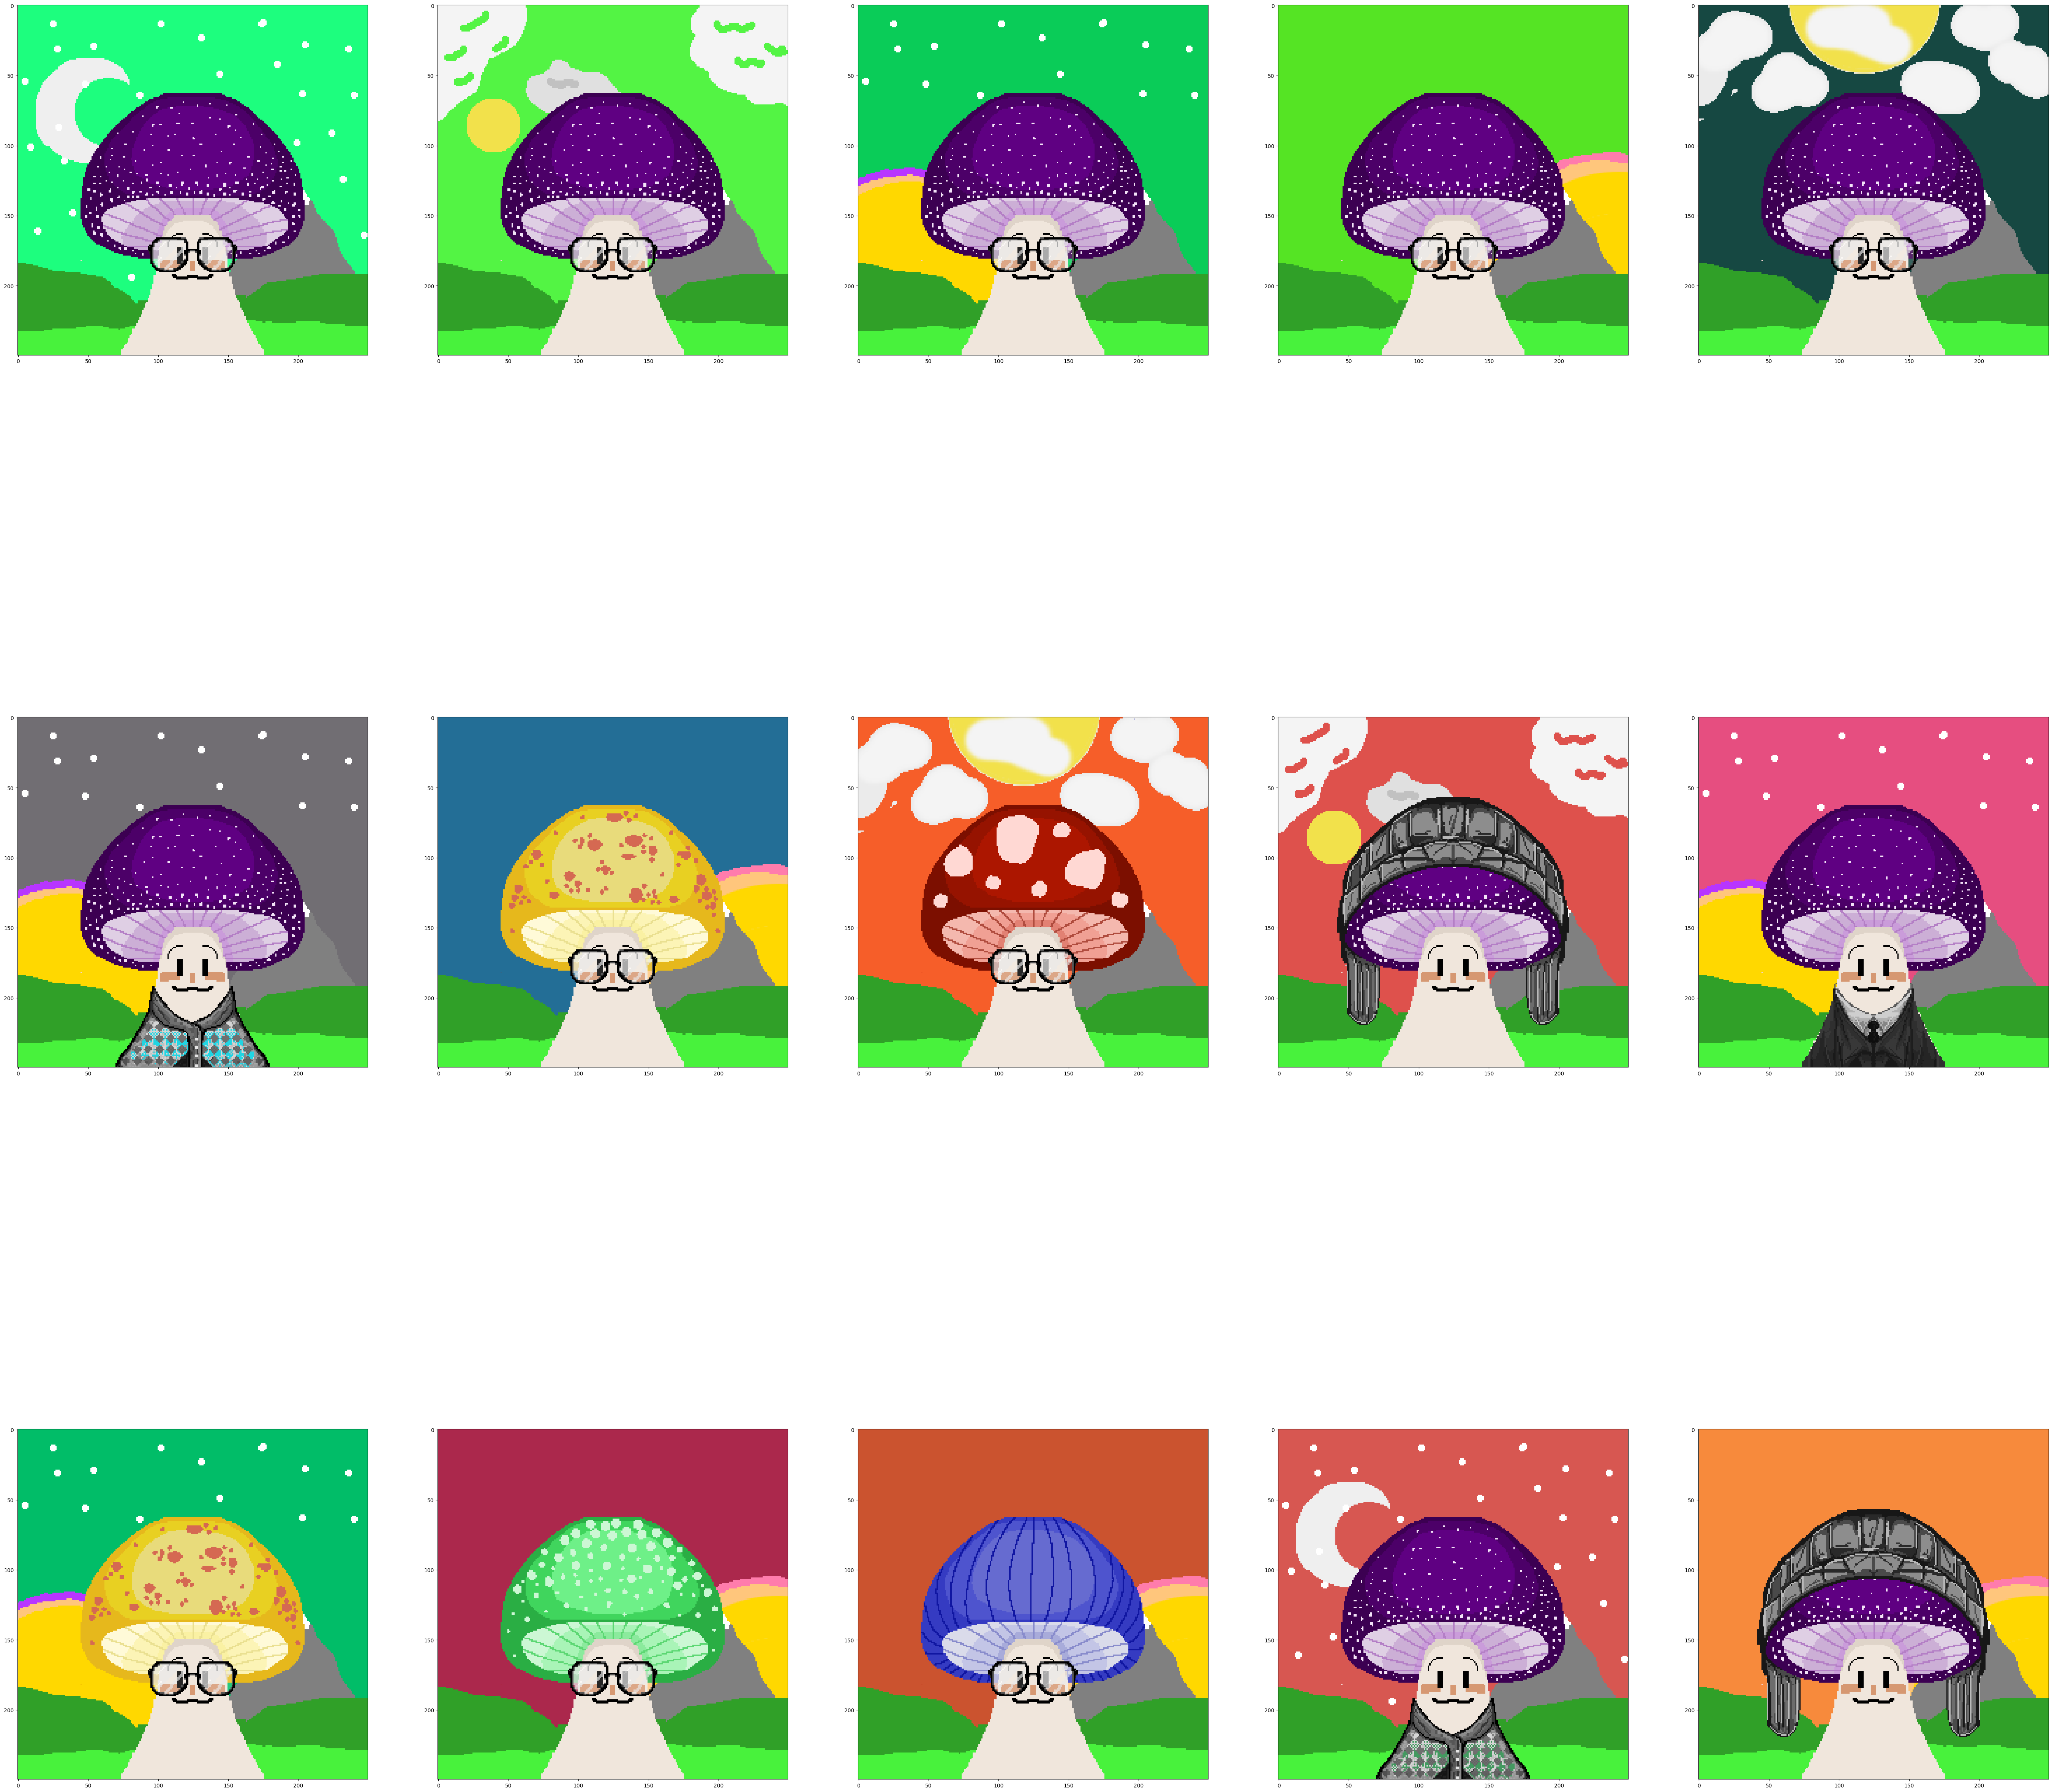

In [12]:
# creating the grid with the collection already sorted

factory.show_grid(15, 5)

**Exporting the generated NFTs**

- This function willexport each individual NFT as a `png` in a folder `generated`, you can select a different directory if needed

In [8]:
# note that if your directories do not match it will generate an error
factory.save("./assets/generated")